In [19]:
# Import modules needed
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import pickle
import glob
from IPython.display import Image
from PIL import Image as PILImage
from random import shuffle
import data_processing
from ipywidgets import widgets


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import util
from vqa_model import Encoder, Decoder, VQASystem
from squeezenet import SqueezeNet
from vgg16 import VGG16
import graph_builder

from compact_bilinear_pooling import compact_bilinear_pooling_layer

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Load data (excluding images)

# Restrict the number of possible answers using this
# Decreasing this will increase the number of classes 
train_min_count = 99
val_cutoff = 107183
# Load data
dataset = util.load_data_all(train_min_count, val_cutoff=107183, limit=100000000)
np_embeddings = np.load("data/glove.trimmed.100.npz")["glove"]
answer_to_id, id_to_answer = util.load_answer_map(min_count=train_min_count)
with open('data/qid_to_anstype.dat', 'rb') as fp:
    qid_to_anstype = pickle.load(fp)
    
vocab, rev_vocab = data_processing.initialize_vocabulary()

# print("*" * 60)
# print("Questions_train", dataset.train.questions.shape)
# print("Questions_mask_train", dataset.train.mask.shape)
# print("Questions_ids_train", dataset.train.question_ids.shape)
# print("Image_ids_train", dataset.train.image_ids.shape)
# print("All_answers_train", dataset.train.all_answers.shape)
# print("Answers_train", dataset.train.answers.shape)
# print("*" * 60)
# print("Questions_val", dataset.val.questions.shape)
# print("Questions_mask_val", dataset.val.mask.shape)
# print("Questions_ids_val", dataset.val.question_ids.shape)
# print("Image_ids_val", dataset.val.image_ids.shape)
# print("All_answers_val", dataset.val.all_answers.shape)
# print("Answers_val", dataset.val.answers.shape)
# print("*" * 60)
# print("Questions_test", dataset.test.questions.shape)
# print("Questions_mask_test", dataset.test.mask.shape)
# print("Questions_ids_test", dataset.test.question_ids.shape)
# print("Image_ids_test", dataset.test.image_ids.shape)
# print("All_answers_test", dataset.test.all_answers.shape)
# print("Answers_test", dataset.test.answers.shape)
# print("*" * 60)
# print("np_embeddings", np_embeddings.shape)
# print("*" * 60)
# print("There are", len(answer_to_id), "possible answers (including <unk>)")
# print("This should be less than or equal to above", np.max(dataset.train.answers) + 1) 
# print("This should be less than or equal to above", np.max(dataset.val.answers) + 1) 
# print("This should be less than or equal to above", np.max(dataset.test.answers) + 1) 
# print("This should be less than or equal to above", np.max(dataset.train.all_answers) + 1) 
# print("This should be less than or equal to above", np.max(dataset.val.all_answers) + 1) 
# print("This should be less than or equal to above", np.max(dataset.test.all_answers) + 1) 
# print("*" * 60)

In [21]:
vqa_system = graph_builder.build_bipool_kunmi()

Done Adding Placeholers!
Done Adding Embedding!
vgg_out Tensor("qa/conv5_3:0", shape=(?, 14, 14, 512), dtype=float32)
q_enc Tensor("qa/vqa_additional/dropout/mul:0", shape=(?, 512), dtype=float32)
q_tile Tensor("qa/vqa_additional/Tile:0", shape=(?, 14, 14, 512), dtype=float32)
q_im_attn Tensor("qa/vqa_additional/Reshape_3:0", shape=(?, ?, ?, ?), dtype=float32)
attn_conv1 Tensor("qa/vqa_additional/Relu:0", shape=(?, ?, ?, 512), dtype=float32)
attn_conv2 Tensor("qa/vqa_additional/add_1:0", shape=(?, ?, ?, 1), dtype=float32)
alpha Tensor("qa/vqa_additional/Reshape_5:0", shape=(?, 14, 14, 1), dtype=float32)
weighted Tensor("qa/vqa_additional/mul:0", shape=(?, 14, 14, 512), dtype=float32)
attended_image Tensor("qa/vqa_additional/dropout_1/mul:0", shape=(?, 512), dtype=float32)
a Tensor("qa/vqa_additional/HERE1:0", shape=(?, 1, 1, 512), dtype=float32)
b Tensor("qa/vqa_additional/HERE2:0", shape=(?, 1, 1, 512), dtype=float32)
attd_im_q Tensor("qa/vqa_additional/Reshape_9:0", shape=(?, 8000), 

In [22]:
train_saved_model = True
sess = tf.Session()
util.initialize_model(sess, vqa_system, vqa_system.config.model_dir, 
                      train_saved_model,config=vqa_system.config) 





Reading model parameters from bilinear_model/model.ckpt


In [23]:
import random
from IPython.display import clear_output
input_files = glob.glob("data/preprocessed_images_val/*")
shuffle(input_files)

questionText = widgets.Text()
imageText = widgets.Text()
answerText = widgets.Text()
my_obj = {}

sampleButton = widgets.Button(description="Get new sample!")
def sample_images(button):
    #print("HI")
    clear_output()
    s = random.sample(input_files, 4)
    plt.figure(figsize=(12, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        print(input_files[i])
        img = np.asarray(PILImage.open(input_files[i]))
        plt.imshow(img)
        plt.axis('off')
    plt.gcf().tight_layout()
sampleButton.on_click(sample_images)

def ask(textBox):
    my_obj["question"] = textBox.value
    answer, attention = vqa_system.answer_my_question(sess, my_obj["image"], 
                                                      my_obj["question"], vocab, rev_vocab, 
                                     answer_to_id, id_to_answer)
    answerText.value = answer
questionText.on_submit(ask)

def select(textBox):
    clear_output()
    my_obj["image"] = np.asarray(PILImage.open('data/preprocessed_images_val/'+ str(textBox.value)+'.jpeg'))
    plt.figure(figsize=(4, 4))
    plt.imshow(my_obj["image"])
    
imageText.on_submit(select)

data/preprocessed_images_val/288944.jpeg
data/preprocessed_images_val/173553.jpeg
data/preprocessed_images_val/101420.jpeg
data/preprocessed_images_val/134103.jpeg


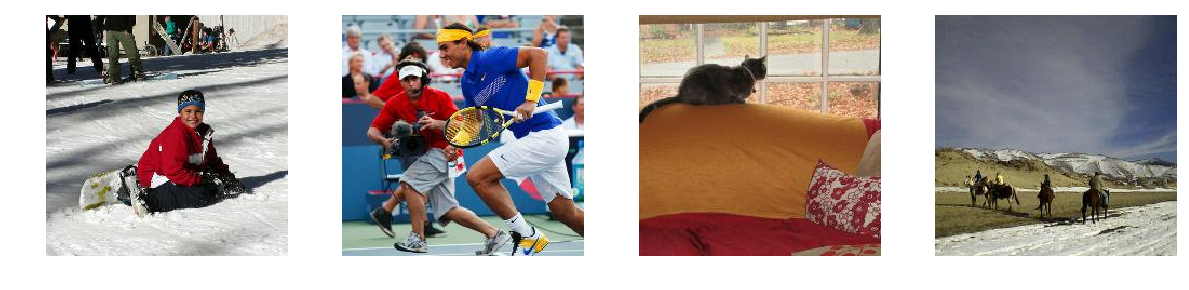

In [24]:
display(sampleButton)

In [25]:
imageText

In [26]:
questionText

In [27]:
answerText